# 量化策略交易



In [1]:
from bs4 import BeautifulSoup
import requests
import nltk
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.tag import pos_tag, PerceptronTagger
from collections import Counter

from wordcloud import WordCloud
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))
custom_words = ['committee', 'rate', 'federal', 'percent', 'range']

for word in custom_words:
    stop_words.add(word)

!python -m nltk.downloader punkt



C:\Users\junji\anaconda3\lib\runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\junji\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
fomc=pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRxy9-y_w65YIJsU6eHtjeiqLrXGkUWMHjiObfJG81223b78M8MUrIt5jIiKYF0qw/pub?output=csv")

In [3]:
def extract_fomc_statement(date):
    #scrape information from the Fed's website
    response = requests.get(f'https://www.federalreserve.gov/newsevents/pressreleases/monetary{date}a.htm')
    html_content = response.text
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the main content container with the specified classes
    main_container = soup.find('div', class_='container__main')

    # Find all paragraphs within the main container
    paragraphs = main_container.find_all('p')

    # Exclude the first paragraph (heading) and the last paragraph
    relevant_paragraphs = paragraphs[2:-1]

    # Extract and concatenate the text from the relevant paragraphs
    statement_text = ' '.join(p.get_text().strip() for p in relevant_paragraphs)
    statement_text = re.sub(r'Voting for the(?: FOMC)?[\s\S]*?(?:\d|\]).', '', statement_text)

    return statement_text

In [4]:
def text1(text):
    strings = re.sub('\s+', ' ', text)


    strings = re.sub('[^a-zA-Z0-9]+', ' ',text)

    strings = re.sub('Romanized', ' ', text)
    tokenized_strings = []
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_strings.extend(tokenizer.tokenize(strings.lower()))

    counter = Counter(tokenized_strings)

    top_20_tokens = counter.most_common(20)

    tokenized_lyrics_no_stop = []
    stop_words = stopwords.words('english')

    excluded_words = ["committee","federal"]

    for token in tokenized_strings:
        if token not in stop_words and token not in excluded_words:
            tokenized_lyrics_no_stop.append(token)

    top_20_stems = Counter(tokenized_lyrics_no_stop).most_common(20)


    return top_20_stems

In [5]:
#这行要爬外网，运行的话可能稍微久一点
fomc["text"]=fomc["Date"].apply(extract_fomc_statement)

In [6]:
fomc["freq"]=fomc["text"].apply(text1)


In [7]:
fomc['concern'] = fomc['freq'].apply(lambda x: next((t[0] for t in x if t[0] in ['inflation', 'economic']), None))

In [8]:
fomc

,Date,text,freq,concern
0,20230503,Economic activity expanded at a modest pace in...,"[(inflation, 9), (policy, 6), (economic, 5), (...",inflation
1,20230322,Recent indicators point to modest growth in sp...,"[(inflation, 9), (policy, 7), (monetary, 6), (...",inflation
2,20230201,Recent indicators point to modest growth in sp...,"[(inflation, 8), (monetary, 5), (policy, 5), (...",inflation
3,20221214,Recent indicators point to modest growth in sp...,"[(inflation, 9), (economic, 5), (monetary, 5),...",inflation
4,20221102,Recent indicators point to modest growth in sp...,"[(inflation, 9), (economic, 5), (monetary, 5),...",inflation
...,...,...,...,...
135,20060808,The Federal Open Market Committee decided toda...,"[(inflation, 6), (market, 2), (economic, 2), (...",inflation
136,20060629,The Federal Open Market Committee decided toda...,"[(inflation, 6), (economic, 3), (growth, 3), (...",inflation
137,20060510,The Federal Open Market Committee decided toda...,"[(inflation, 4), (economic, 3), (growth, 3), (...",inflation
138,20060328,The Federal Open Market Committee decided toda...,"[(growth, 4), (economic, 3), (inflation, 3), (...",economic


In [9]:
groupeddf=fomc.groupby("concern")


# **Yearly analysis**

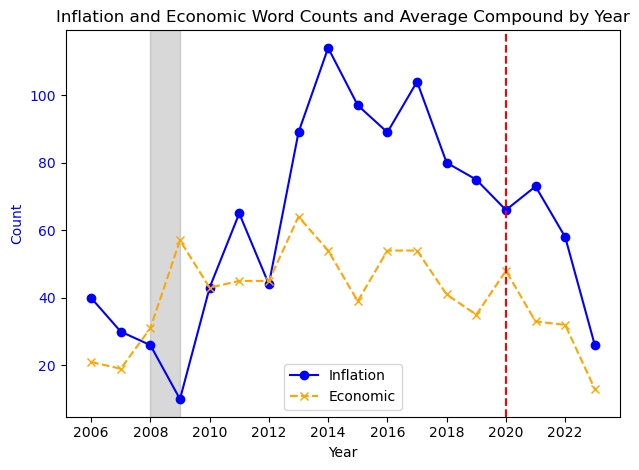

In [10]:
import matplotlib.pyplot as plt

# Convert 'Date' column to datetime object
fomc['Date1'] = pd.to_datetime(fomc['Date'], format='%Y%m%d')

# Extract year from the 'Date' column
fomc['Year'] = fomc['Date1'].dt.year

# Extract first value from each list in 'freq' column
fomc['Inflation'] = fomc['freq'].apply(lambda x: dict(x).get('inflation', 0))
fomc['Economic'] = fomc['freq'].apply(lambda x: dict(x).get('economic', 0))

# Group by 'Year' and calculate sum and mean
yearly_counts = fomc.groupby('Year')[['Inflation', 'Economic']].sum()

# Create separate lists for each plot
years = yearly_counts.index.tolist()
inflation_counts = yearly_counts['Inflation'].tolist()
economic_counts = yearly_counts['Economic'].tolist()

# Create the plot
fig, ax1 = plt.subplots()

# Plot the data on the primary y-axis
line1 = ax1.plot(years, inflation_counts, label='Inflation', marker='o', linestyle='-', color='blue')
line2 = ax1.plot(years, economic_counts, label='Economic', marker='x', linestyle='--', color='orange')

# Highlight the years 2008-2009 with a shaded region and 2023 with a dashed line
ax1.axvspan(2008, 2009, color='gray', alpha=0.3)
ax1.axvline(2020, color='red', linestyle='--')

# Customize the plot for the primary y-axis
ax1.set_xlabel('Year')
ax1.set_ylabel('Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Set x-axis to display integer years
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Remove grid lines
ax1.grid(False)

# Set the plot title
plt.title('Inflation and Economic Word Counts and Average Compound by Year')

# Combine legends
lines = line1 + line2 
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=0)

# Show the plot
plt.tight_layout()
plt.show()



# Stock Price

In [11]:
import yfinance as yf
from datetime import datetime, timedelta
hist=yf.Ticker("^GSPC").history(start="2005-01-01",end="2023-06-26")

In [12]:
fomc['Date'] = pd.to_datetime(fomc['Date'], format='%Y%m%d')

In [13]:
hist['MA5'] = hist['Close'].rolling(window=5).mean()
hist['MA10'] = hist['Close'].rolling(window=10).mean()
hist['MA20'] = hist['Close'].rolling(window=20).mean()
hist['MA120']=hist['Close'].rolling(window=120).mean()
hist['MA200']=hist['Close'].rolling(window=200).mean()

In [14]:
def pricen (date):
    try:
        date=str(date)[:10]
        # convert the date string to a datetime object
        date_obj = datetime.strptime(date, "%Y-%m-%d")

        new_date = date_obj.strftime("%Y-%m-%d")
        return float(hist.loc[new_date]["Close"])
    except:

        # convert the date string to a datetime object
        date_obj = datetime.strptime(date, "%Y-%m-%d")

        # subtract two days from the date object
        new_date_obj = date_obj - timedelta(days=2)

        # convert the new date object back to a string with the desired format
        new_date = new_date_obj.strftime("%Y-%m-%d")
        return float(hist.loc[new_date]["Close"])

def MA20f (date):
    try:
        date=str(date)[:10]
        # convert the date string to a datetime object
        date_obj = datetime.strptime(date, "%Y-%m-%d")

        # convert the new date object back to a string with the desired format
        new_date = date_obj.strftime("%Y-%m-%d")
        return float(hist.loc[new_date]["MA20"])
    except:
        # convert the date string to a datetime object
        date_obj = datetime.strptime(date, "%Y-%m-%d")

        # subtract two days from the date object
        new_date_obj = date_obj - timedelta(days=2)

        # convert the new date object back to a string with the desired format
        new_date = new_date_obj.strftime("%Y-%m-%d")
        return float(hist.loc[new_date]["MA20"])

def MA200f (date):
    try:
        date=str(date)[:10]
        # convert the date string to a datetime object
        date_obj = datetime.strptime(date, "%Y-%m-%d")

        # convert the new date object back to a string with the desired format
        new_date = date_obj.strftime("%Y-%m-%d")
        return float(hist.loc[new_date]["MA200"])
    except:
        # convert the date string to a datetime object
        date_obj = datetime.strptime(date, "%Y-%m-%d")

        # subtract two days from the date object
        new_date_obj = date_obj - timedelta(days=2)

        # convert the new date object back to a string with the desired format
        new_date = new_date_obj.strftime("%Y-%m-%d")
        return float(hist.loc[new_date]["MA200"])

def MA10f (date):
    try:
        date=str(date)[:10]
        # convert the date string to a datetime object
        date_obj = datetime.strptime(date, "%Y-%m-%d")

        # convert the new date object back to a string with the desired format
        new_date = date_obj.strftime("%Y-%m-%d")
        return float(hist.loc[new_date]["MA10"])
    except:
        # convert the date string to a datetime object
        date_obj = datetime.strptime(date, "%Y-%m-%d")

        # subtract two days from the date object
        new_date_obj = date_obj - timedelta(days=2)

        # convert the new date object back to a string with the desired format
        new_date = new_date_obj.strftime("%Y-%m-%d")
        return float(hist.loc[new_date]["MA10"])

def MA120f (date):
    try:
        date=str(date)[:10]
        # convert the date string to a datetime object
        date_obj = datetime.strptime(date, "%Y-%m-%d")

        # convert the new date object back to a string with the desired format
        new_date = date_obj.strftime("%Y-%m-%d")
        return float(hist.loc[new_date]["MA120"])
    except:
        # convert the date string to a datetime object
        date_obj = datetime.strptime(date, "%Y-%m-%d")

        # subtract two days from the date object
        new_date_obj = date_obj - timedelta(days=2)

        # convert the new date object back to a string with the desired format
        new_date = new_date_obj.strftime("%Y-%m-%d")
        return float(hist.loc[new_date]["MA120"])

def MA5f (date):
    try:
        date=str(date)[:10]
        # convert the date string to a datetime object
        date_obj = datetime.strptime(date, "%Y-%m-%d")

        # convert the new date object back to a string with the desired format
        new_date = date_obj.strftime("%Y-%m-%d")
        return float(hist.loc[new_date]["MA5"])
    except:
        # convert the date string to a datetime object
        date_obj = datetime.strptime(date, "%Y-%m-%d")

        # subtract two days from the date object
        new_date_obj = date_obj - timedelta(days=2)

        # convert the new date object back to a string with the desired format
        new_date = new_date_obj.strftime("%Y-%m-%d")
        return float(hist.loc[new_date]["MA5"])

def price1 (date):
    date=str(date)[:10]
    try:
        # convert the date string to a datetime object
        date_obj = datetime.strptime(date, "%Y-%m-%d")

        # subtract one days from the date object
        new_date_obj = date_obj + timedelta(days=29)

        # convert the new date object back to a string with the desired format
        new_date = new_date_obj.strftime("%Y-%m-%d")
        return float(hist.loc[new_date]["Close"])
    except:
        try:
            # convert the date string to a datetime object
            date_obj = datetime.strptime(date, "%Y-%m-%d")
            # In case it's a holiday after 30 days.
            new_date_obj = date_obj + timedelta(days=31)

            # convert the new date object back to a string with the desired format
            new_date = new_date_obj.strftime("%Y-%m-%d")
            return float(hist.loc[new_date]["Close"])
        except:

            # convert the date string to a datetime object
            date_obj = datetime.strptime(date, "%Y-%m-%d")

            # In case it's a holiday weekend after 14 days.
            new_date_obj = date_obj + timedelta(days=33)

            # convert the new date object back to a string with the desired format
            new_date = new_date_obj.strftime("%Y-%m-%d")
            return float(hist.loc[new_date]["Close"])

fomc["Close"]=fomc['Date'].apply(pricen)
fomc["MA200"]=fomc['Date'].apply(MA200f)
fomc["MA20"]=fomc['Date'].apply(MA20f)
fomc["MA120"]=fomc['Date'].apply(MA120f)
fomc["MA10"]=fomc['Date'].apply(MA10f)
fomc["MA5"]=fomc['Date'].apply(MA5f)

In [15]:
fomc

,Date,text,freq,concern,Date1,Year,Inflation,Economic,Close,MA200,MA20,MA120,MA10,MA5
0,2023-05-03,Economic activity expanded at a modest pace in...,"[(inflation, 9), (policy, 6), (economic, 5), (...",inflation,2023-05-03,2023,9,5,4090.750000,3969.218413,4123.048511,4003.135010,4121.100024,4136.606055
1,2023-03-22,Recent indicators point to modest growth in sp...,"[(inflation, 9), (policy, 7), (monetary, 6), (...",inflation,2023-03-22,2023,9,4,3936.969971,3934.278164,3957.757507,3915.399677,3921.522021,3953.666016
2,2023-02-01,Recent indicators point to modest growth in sp...,"[(inflation, 8), (monetary, 5), (policy, 5), (...",inflation,2023-02-01,2023,8,4,4119.209961,3952.640416,3975.410034,3911.497186,4026.901025,4068.914014
3,2022-12-14,Recent indicators point to modest growth in sp...,"[(inflation, 9), (economic, 5), (monetary, 5),...",inflation,2022-12-14,2022,9,5,3995.320068,4032.133567,3990.249011,3920.903182,3992.570996,3980.683984
4,2022-11-02,Recent indicators point to modest growth in sp...,"[(inflation, 9), (economic, 5), (monetary, 5),...",inflation,2022-11-02,2022,9,5,3759.689941,4101.216359,3730.511011,3921.433183,3810.171045,3839.226025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2006-08-08,The Federal Open Market Committee decided toda...,"[(inflation, 6), (market, 2), (economic, 2), (...",inflation,2006-08-08,2006,6,2,1271.479980,1269.885551,1261.473511,1280.093834,1274.202014,1276.858008
136,2006-06-29,The Federal Open Market Committee decided toda...,"[(inflation, 6), (economic, 3), (growth, 3), (...",inflation,2006-06-29,2006,6,3,1272.869995,1262.084951,1250.689502,1282.553001,1248.271997,1250.626001
137,2006-05-10,The Federal Open Market Committee decided toda...,"[(inflation, 4), (economic, 3), (growth, 3), (...",inflation,2006-05-10,2006,4,3,1322.849976,1256.163502,1308.764496,1282.542335,1315.750989,1322.132007
138,2006-03-28,The Federal Open Market Committee decided toda...,"[(growth, 4), (economic, 3), (inflation, 3), (...",economic,2006-03-28,2006,3,3,1293.229980,1242.069099,1292.894495,1256.391085,1302.240991,1300.900000


In [16]:
df= fomc.iloc[::-1].reset_index(drop=True)

# Strategy

In [17]:
# Create a 'Buy_Signal' column (True when Close price is greater than the 7-day moving average)

df['Buy_Signal'] = ((df['Close'] > df['MA120'])&(df['concern']=="economic"))|((df['Close'] >df['MA20'])&(df['concern']=='inflation'))

monthly_df = df

# Create 'Action' column ("Buy" when Buy_Signal is True, otherwise "Sell")
monthly_df['Action'] = monthly_df['Buy_Signal'].apply(lambda x: 'Buy' if x else 'Sell')

# We create a new column to denote if we hold a position, initialize it to False
monthly_df['Holding_Position'] = False

# Then, we need to update our 'Holding_Position' column based on our 'Action' column
for i in range(1, len(monthly_df)):
    if monthly_df.iloc[i-1]['Action'] == 'Buy':
        monthly_df.iloc[i, monthly_df.columns.get_loc('Holding_Position')] = True
    elif monthly_df.iloc[i-1]['Holding_Position'] == monthly_df.iloc[i]['Action'] == 'Sell':
        monthly_df.iloc[i, monthly_df.columns.get_loc('Holding_Position')] = False


# Calculate monthly returns
monthly_df['Return'] = monthly_df['Close'].pct_change()

# Calculate strategy returns
monthly_df['Strategy_Return'] = monthly_df['Return']
monthly_df.loc[monthly_df['Holding_Position'] == False, 'Strategy_Return'] = 0
monthly_df['Cumulative_Strategy_Returns'] = (1 + monthly_df['Strategy_Return']).cumprod()
monthly_df['Cumulative_Market_Returns'] = (1 + monthly_df['Return']).cumprod()



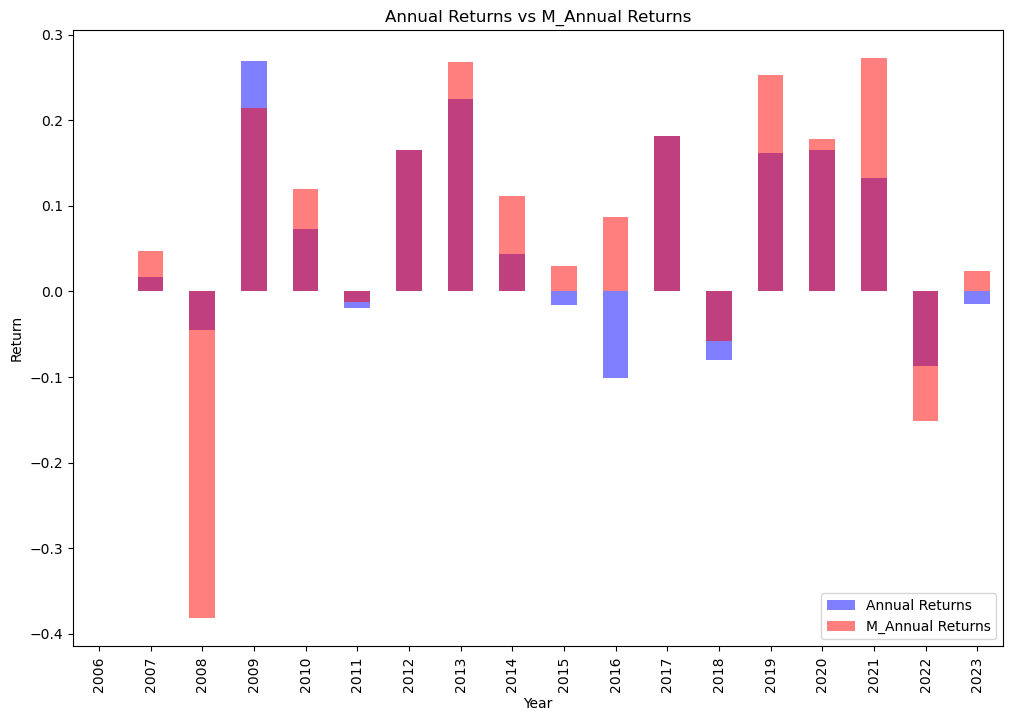

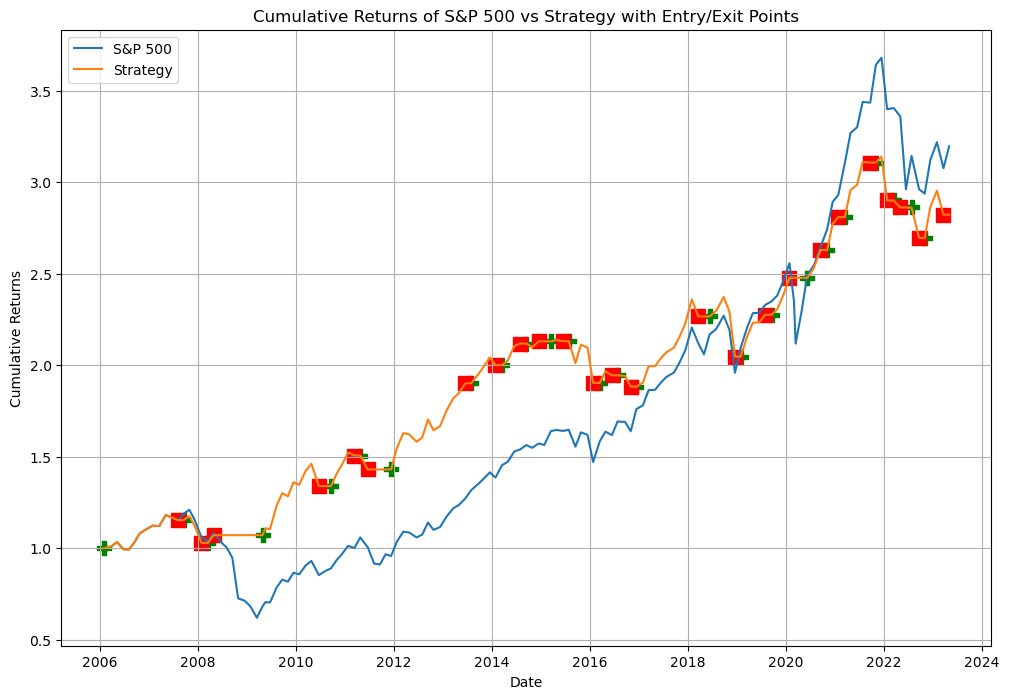

In [18]:
import matplotlib.pyplot as plt
monthly_df.set_index('Date', inplace=True)
annual_df = monthly_df.resample('Y').last()  # Resample to get end of year data
annual_df.index = annual_df.index.year
# Annual returns bar graph
annual_df['Annual_Return'] = annual_df['Cumulative_Strategy_Returns'].pct_change()  # Calculate annual returns
annual_df['m_Annual_Return'] = annual_df['Cumulative_Market_Returns'].pct_change() 

# Plot both bar graphs on the same graph with different colors
annual_df['Annual_Return'].plot(kind='bar', color='b', alpha=0.5, figsize=(12,8))  # 'alpha' is for transparency
annual_df['m_Annual_Return'].plot(kind='bar', color='r', alpha=0.5, figsize=(12,8))

plt.title('Annual Returns vs M_Annual Returns')
plt.xlabel('Year')
plt.ylabel('Return')
plt.legend(['Annual Returns', 'M_Annual Returns'])  # Add a legend to distinguish the bars
plt.show()


monthly_df['Buy_Signal_Shifted'] = monthly_df['Buy_Signal'].shift()
monthly_df['Buy_Signal_Shifted'].fillna(False, inplace=True)

# If Buy_Signal changes from False to True
entry_points = monthly_df[(monthly_df['Buy_Signal'] == True) & (monthly_df['Buy_Signal_Shifted'] == False)].index
# If Buy_Signal changes from True to False
exit_points = monthly_df[(monthly_df['Buy_Signal'] == False) & (monthly_df['Buy_Signal_Shifted'] == True)].index


# Line plot with Entry/Exit points
plt.figure(figsize=(12,8))
plt.plot(monthly_df['Cumulative_Market_Returns'], label='S&P 500')
plt.plot(monthly_df['Cumulative_Strategy_Returns'], label='Strategy')

# Plot Entry points
for point in entry_points:
    plt.scatter(point, monthly_df.loc[point, 'Cumulative_Strategy_Returns'], marker='P', s=100, color='g')

# Plot Exit points
for point in exit_points:
    plt.scatter(point, monthly_df.loc[point, 'Cumulative_Strategy_Returns'], marker='s', s=100, color='r')

plt.title('Cumulative Returns of S&P 500 vs Strategy with Entry/Exit Points')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()


# Sharp Ratio

In [19]:
# Reset index and convert 'Date' index into column
monthly_df = monthly_df.reset_index()

# Ensure 'Date' column is in datetime format
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'])

# Compute the difference in days between each row and the previous one
monthly_df['Date_diff'] = monthly_df['Date'].diff().dt.days

# Download risk-free rate data
rf_rate = yf.download('^IRX', start="2006-01-30", end="2023-05-04")


[*********************100%***********************]  1 of 1 completed


In [20]:
# Convert index to datetime
rf_rate.index = pd.to_datetime(rf_rate.index)

# Map risk-free rate to your dataframe based on date
monthly_df['Risk_Free_Rate'] = monthly_df['Date'].map(rf_rate['Close'])
monthly_df['rf']=monthly_df['Risk_Free_Rate']*monthly_df['Date_diff']/360/100

In [21]:
strategy_returns = np.array(monthly_df["Strategy_Return"])
excess_returns = strategy_returns - monthly_df['rf']
sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
sharpe_ratio

0.19916784568129406

# 最大回撤

In [22]:
# Calculate the running maximum
monthly_df['Running_Max'] = monthly_df['Cumulative_Strategy_Returns'].cummax()

# Calculate the running drawdown
monthly_df['Drawdown'] = monthly_df['Running_Max'] - monthly_df['Cumulative_Strategy_Returns']

# Calculate the maximum drawdown
max_drawdown = monthly_df['Drawdown'].max()

max_drawdown


0.4444801400414886